In [2]:
import numpy as np
import networkx as nx
import random
import time
import csv
import os
import pandas as pd
from matplotlib import pyplot as plt

from numpy.random import exponential as npexponential
from numpy.random import choice as npchoice
from numpy.random import randint 
from random import random as rrandom
from random import choice as rchoice
from math import log as ln
from scipy.stats import pearsonr

from helper_functions import *
import gillespie_code as gc

First, we simulate the dynamics in a static ER-graph with the adaptation rules turned off (*HSP=False*). Number of nodes (*n*) is 500 and the simulation is ended when either all activity dies out (unless spontaneous firing is allowed) or *t_max* is reached. Inactive nodes are allowed to fire spontaneously at rate *spont_rate* if *spontaneous_firing=True*. The simulation is initialized by randomly activating 0.05% of the nodes (*fraction_firing*). The arguments *i_to_f*, *f_to_r* and *r_to_i* determine the rates at which nodes transition from one state to another.

If we are interested in the average activity only after transients have died out, we can use the parameter *transient* to determine how large part of the beginning of the simulation should be ignored.

The function returns a *networkx* graph *G*, the realized mean degree and a class instance *runvars*, which stores the results. 

In [3]:
G,avgdeg_realized,runvars = gc.gillespie(graphtype = "ER", avg_deg=2.5, t_max = 2000, n = 500,
                                         i_to_f = 0.7, f_to_r = 0.95, r_to_i = 0.4, 
                                           HSP = False, spontaneous_firing = True, spont_rate = 10**(-6),
                                          fraction_firing = 0.05,
                                           verbose = False, transient = 500)

In [4]:
print("Average activity:", runvars.A, ", average activity after transient:", runvars.A_transient)

Average activity: 0.000726012492272044 , average activity after transient: 0.0005164373416868908


Instead of creating a random ER-graph, we can also create our own *networkx*-graph *G* and use that graph in the simulation by setting *graphtype=G*. In the following, we activate only one node and track the duration and the size of the resulting activation cascade (size is defined as the number of times a node transitions from inactive to firing). Note that in the current version of the code, these quantities make sense only when the adaptation rules are turned off.

In [8]:
G,avgdeg_realized,runvars = gc.gillespie(graphtype = G, avg_deg=_, t_max = 2000, n = _,
                                           HSP = False, spontaneous_firing = False, spont_rate = 10**(-6),
                                          fraction_firing = 1/500,
                                           verbose = False, transient = 500)

print("Duration:", runvars.dur, ", size: ", runvars.comp_size)

Duration: 0.0646947406158233 , size:  1


Next, we turn the adaptation rules on by setting *HSP=True*. Firing nodes lose links at rate *l* and links are created between random nodes at rate $l \times epsilon$. The argument *record_step* determines how often the network parameters (such as the leading eigenvalue of the adjacency matrix etc) are calculated. Note that calculating these quantities takes some time especially for large networks.

In [9]:
G,avgdeg_realized,runvars = gc.gillespie(graphtype = "ER", avg_deg=2, t_max = 2000, n = 500,
                                           HSP = True, l = 0.001, epsilon = 0.01, spontaneous_firing = True, 
                                          spont_rate = 10**(-6),
                                          fraction_firing = 0.05,
                                           verbose = False, transient = 500,record_step = 200, writeout=False)

Now we can plot the tracked network parameters: average degree $\langle k \rangle $, leading eigenvalue $\lambda_1$ of the adjacency matrix, average excess degree $\langle q \rangle $ and the average correlation coefficient $\rho$ between nodes' in- and out-degrees. 

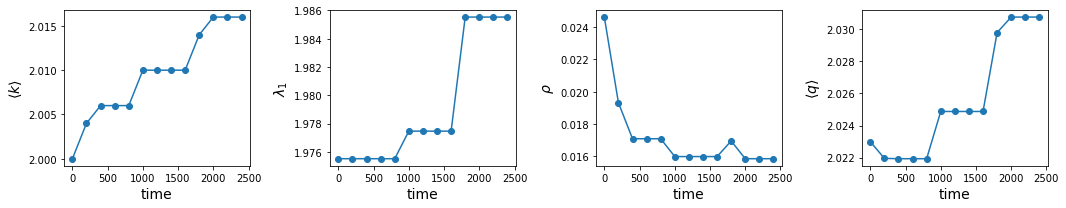

In [10]:
fig, ax = plt.subplots(1,4,figsize = (15,3),sharex = True)

vals = [runvars.kmeans,runvars.lams, runvars.corrs,runvars.excessdegs]
ylabels = [r"$\langle k \rangle $", r"$\lambda_1$", r"$\rho$", r"$\langle q \rangle $"]

for i in range(len(ax)):
    ax[i].plot(runvars.tvals,vals[i],marker ="o")
    ax[i].set_ylabel(ylabels[i],size=14)
    ax[i].set_xlabel("time",size = 14)
        
plt.tight_layout()

If *writeout==True*, these results are written to a file (to avoid opening the file too frequently, the argument *writeout_step* determines how often the results are written to the file; this becomes relevant with long runs). You can determine the directory with the argument *dir*. Two subdirectories will be created inside this directory. First, the network parameters are written to a file inside a subdirectory *kmeans*. In addition, two files are written to a subdirectory *edgechanges*; one *networkx*-edgelist listing the links at the start of the simulation, and one listing all the link removals and additions during the simulation ("1" denotes an addition while "-1" denotes a removal in this file). 

In case you run several simulations with the same parameters, you can identify the files corresponding to the different runs by using the argument *idval*.

In addition to the parameters plotted above, we can track how long each node spends in the firing state by setting *testF = True*. This will also produce another dictionary called *firing_times* recording the times a node transitions from inactive to firing, starting from *firing_track_start* until *firing_track_start+firing_track_dur* is reached.

Text(0, 0.5, 'time in state F')

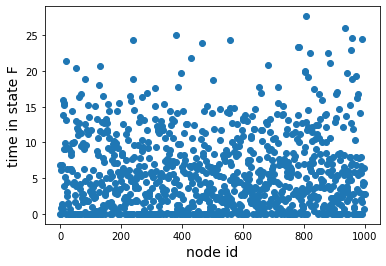

In [12]:
G,avgdeg_realized,runvars = gc.gillespie(graphtype = "ER", avg_deg=2.5, t_max = 10000, n = 1000,
                                        testF = True, firing_track_start = 8000, firing_track_dur=100)
                                        
plt.scatter(runvars.testFs.keys(),runvars.testFs.values())
plt.xlabel("node id",size=14)
plt.ylabel("time in state F",size=14)

We can also track the size of the largest strongly connected component by setting *track_SCC=True*. 

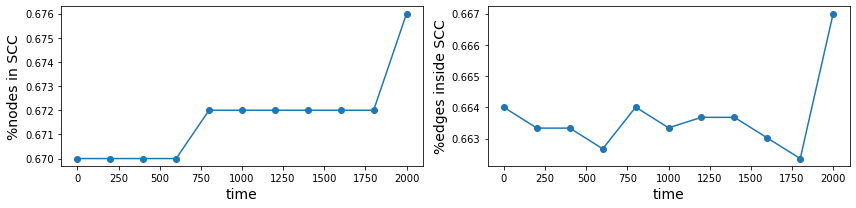

In [13]:
G,avgdeg_realized,runvars = gc.gillespie(graphtype = "ER", avg_deg=2, t_max = 2000, n = 500,
                                           HSP = True, spontaneous_firing = True, 
                                          spont_rate = 10**(-6), record_step = 200, writeout=False, track_SCC = True)


fig, ax = plt.subplots(1,2,figsize = (12,3),sharex = True)

vals = [runvars.scc_sizes, runvars.scc_edges]
ylabels = ["%nodes in SCC", "%edges inside SCC"]

for i in range(len(ax)):
    ax[i].plot(runvars.tvals,vals[i],marker ="o")
    ax[i].set_ylabel(ylabels[i],size=14)
    ax[i].set_xlabel("time",size = 14)
        
plt.tight_layout()

In case you want to track some other network parameters, you can easily do so by initializing a list inside the class *SimulationVariables* and adding a piece of code to calculate and append the parameter to that list inside the function *track_stuff()*.